In [50]:
%run Common.ipynb

import os.path
import pandas as pd

#!pip install surprise
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.model_selection.validation import cross_validate

np.set_printoptions(suppress=True,floatmode='maxprec_equal')

In [51]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

In [52]:
# define some trimming functions

# get unpopular movies
movie_rating_count = ratings_df.groupby('movieId').movieId.agg('count')
unpopular_movie_ids = np.array(movie_rating_count.loc[movie_rating_count <= 2].index)
# the surprise library treats all user/item ids as strings, so convert to strings
unpopular_movie_ids = unpopular_movie_ids.astype(str)

# trim out unpopular movies
def trim_unpopular(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[~df_testset.movieId.isin(unpopular_movie_ids)]
    return df_testset.values.tolist()

# trim out popular movies
def trim_popular(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[df_testset.movieId.isin(unpopular_movie_ids)]
    return df_testset.values.tolist()

# get high variance movies
df_var_count = pd.DataFrame(ratings_df.groupby('movieId').rating.agg(['var','count']).dropna())
# retain only rows with var >= 2.0 and count >= 5
df_var_count = df_var_count.loc[(df_var_count['count'] >= 5) & (df_var_count['var'] >= 2.0)]
high_var_movie_ids = np.array(df_var_count.index).astype(str)

# trim out low variance
def trim_low_variance(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[df_testset.movieId.isin(high_var_movie_ids)]
    return df_testset.values.tolist()

In [53]:
# utility function to cross validate and score
def cross_validate_and_score(svd_k, kfold, trim_func):
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    for trainset, testset in kfold.split(data):
        svd = SVD(n_factors=svd_k, biased=True)
        testset_trimmed = trim_func(testset)
        if len(testset_trimmed) > 0:
            svd.fit(trainset)
            predictions = svd.test(testset_trimmed, verbose=False)
            test_rmse = np.append(test_rmse, accuracy.rmse(predictions, verbose=False))
            test_mae = np.append(test_mae, accuracy.mae(predictions, verbose=False))
        else:
            test_rmse = np.append(test_rmse, 0)
            test_mae = np.append(test_mae, 0)
        
    return {'test_rmse_avg':test_rmse.mean(), 'test_mae_avg':test_mae.mean()}

In [54]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [55]:
cols = ['k','Avg RMSE', 'Avg MAE']

k_list = np.linspace(2,50,25).astype(int)
k_list

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48, 50])

<h1>Question 26</h3>

In [56]:
df_svd_popular_measures = pd.DataFrame(columns=cols)

for svd_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(svd_k, KFold(n_splits=10), trim_unpopular)
        
    df_svd_popular_measures = df_svd_popular_measures.append({cols[0]:svd_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_svd_popular_measures.set_index('k', inplace=True)


In [57]:
df_svd_popular_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   0.880224  0.677983
4.0   0.880664  0.677780
6.0   0.879866  0.677252
8.0   0.880973  0.678782
10.0  0.879068  0.676611
12.0  0.880278  0.677927
14.0  0.880046  0.677656
16.0  0.879676  0.677100
18.0  0.880040  0.677238
20.0  0.879211  0.676325

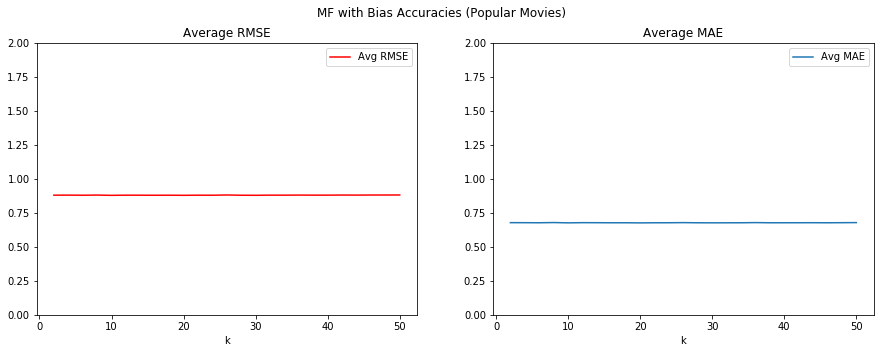

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("MF with Bias Accuracies (Popular Movies)")
df_svd_popular_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(0,2.0), xticks=np.linspace(0,50,6), color='red')
_ = df_svd_popular_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(0,2.0), xticks=np.linspace(0,50,6))

In [10]:
print('The  minimum average RMSE is: %4.6f'%df_svd_popular_measures['Avg RMSE'].min())

The  minimum average RMSE is: 0.879068


<h1>Question 27</h1>

In [11]:
df_svd_unpopular_measures = pd.DataFrame(columns=cols)

for svd_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(svd_k, KFold(n_splits=10), trim_popular)
        
    df_svd_unpopular_measures = df_svd_unpopular_measures.append({cols[0]:svd_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_svd_unpopular_measures.set_index('k', inplace=True)


In [12]:
df_svd_popular_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   0.880224  0.677983
4.0   0.880664  0.677780
6.0   0.879866  0.677252
8.0   0.880973  0.678782
10.0  0.879068  0.676611
12.0  0.880278  0.677927
14.0  0.880046  0.677656
16.0  0.879676  0.677100
18.0  0.880040  0.677238
20.0  0.879211  0.676325

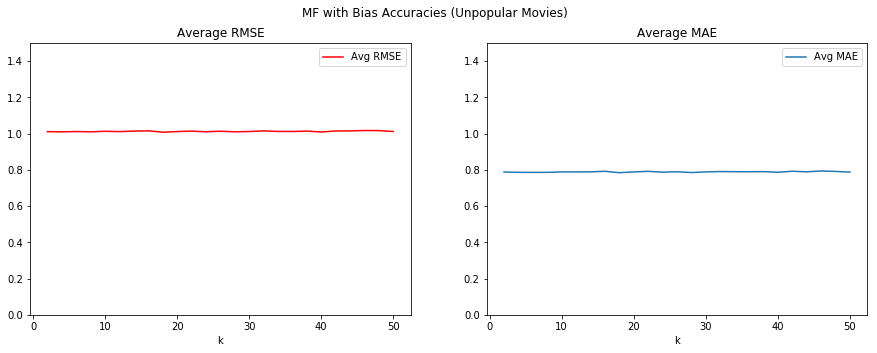

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("MF with Bias Accuracies (Unpopular Movies)")
df_svd_unpopular_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(0,1.5), xticks=np.linspace(0,50,6), color='red')
_ = df_svd_unpopular_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(0,1.5), xticks=np.linspace(0,50,6))

In [14]:
print('The  minimum average RMSE is: %4.6f'%df_svd_unpopular_measures['Avg RMSE'].min())

The  minimum average RMSE is: 1.007790


<h1>Question 28</h1>

In [46]:
df_svd_high_var_measures = pd.DataFrame(columns=cols)

for svd_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(svd_k, KFold(n_splits=10), trim_low_variance)
        
    df_svd_high_var_measures = df_svd_high_var_measures.append({cols[0]:svd_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_svd_high_var_measures.set_index('k', inplace=True)


In [16]:
df_svd_high_var_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.012721  0.788961
4.0   1.008390  0.787444
6.0   1.013273  0.790218
8.0   1.009892  0.788180
10.0  1.011213  0.787639
12.0  1.011802  0.787832
14.0  1.010808  0.788043
16.0  1.010538  0.788165
18.0  1.015212  0.790130
20.0  1.009053  0.787702

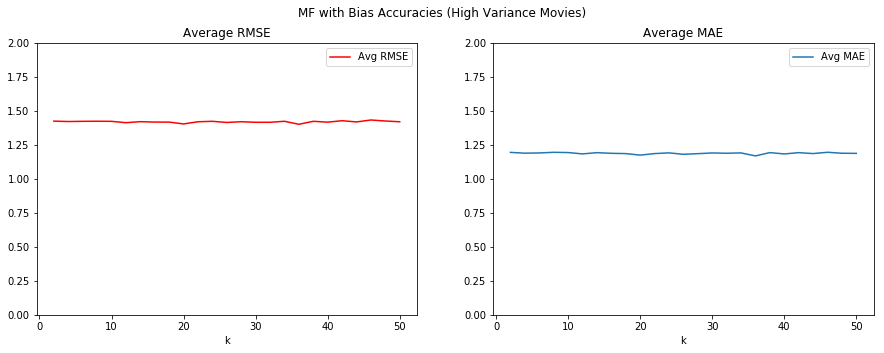

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("MF with Bias Accuracies (High Variance Movies)")
df_svd_high_var_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(0.0,2.0), xticks=np.linspace(0,50,6), color='red')
_ = df_svd_high_var_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(0.0,2.0), xticks=np.linspace(0,50,6))

In [49]:
print('The  minimum average RMSE is: %4.6f'%df_svd_high_var_measures['Avg RMSE'].min())

The  minimum average RMSE is: 1.401975
